In [1]:
import sys
# %store -r SYSPATHS
SYSPATHS = {"tool":"../../../tool"}
sys.path.append(SYSPATHS['tool'])
import Khfeature as kf
import Khcore1 as kc1
from imp import reload
import MyEcharts as me
import pylab as pl
import seaborn as sns
import pandas as pd
import numpy as np
import os
from sklearn.preprocessing import MinMaxScaler,StandardScaler
from sklearn import linear_model
import pickle

reload(kc1)
reload(kf)

<module 'Khfeature' from '../../../tool\\Khfeature.py'>

In [2]:
step = "1min"  ## 计算步进间隔
## 选用三个 不同的时间尺度
value_window = "3min"  ## 平均温度计算窗口: 平均温度的窗口尽量小, 体现其短时作用, 可以快速结束报警, 尺度也不能太短, 防止label毛刺 
roll_window = '15min'  ## 滑动计算窗口: 滑动窗口用于计算Q1,Q3,IQR 和 diff, 滑动窗口下的统计量, 时间可以稍微长点
slope_window = "15min"  ## 斜率计算窗口: 滑动温度斜率窗口, 因为温度存在小范围周期波动, 所以需要将时间窗口放大
th = 6 ## 报警温度阈值
rate = 0.6  ## 报警概率阈值

## 一、获取原始数据

In [10]:
## 0. 获取中碳点表
rdf = pd.read_csv("./data/process/PHlabel.csv",index_col=0)
rdf.index = pd.to_datetime(rdf.index)
data= rdf[(rdf.index>"2018-09-22")&(rdf.index<"2018-10-07")]
# data = data.resample("1min").mean()
data = data.sort_index()
data = data.dropna()
label = data[['label']]

## 二、自动打标签
    根据浓缩段平均温度 生成label

In [12]:
s1 = kf.SingleTsFeature(data.PH-th)  ##  将原始温度 减去 温度阈值 加工特征
s1.add_roll_quantile(q = 0.75,window=roll_window,varname = "q3")
s1.add_roll_quantile(q = 0.25,window=roll_window,varname = "q1")
s1.add_slope(window=slope_window)

add q3 successful 
add q1 successful 


../../../tool\Khfeature.py:210: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
  self._df[varname] = self._df[self._column].rolling(window=window).apply(kc1.gradient)


add_slope successful 


## 三、特征加工

### 1. 浓缩温度 value : value_window 下的 SO2最大值
### 2. 浓缩温度 iqr ：roll_window 下的 SO2的 IQR
### 3. 浓缩温度 slope ：slope_window 下的 拟合斜率

##### 利用 SingleTsFeature 对 TE_1003 加工特征变量

In [13]:
###  2. 某些特征 用户可自行生成
df = s1.GetDf()
df['value'] = df['PH'].rolling(value_window).max()
df['iqr'] = df['q3']-df['q1']
df = pd.concat([df,label],axis=1)
df = df.dropna()
temp = df[["value",'iqr','slope','label']]
temp = (temp-temp.min())/(temp.max()-temp.min())
me.Plot_LineBar(df,name='PH_Feature_label_06',overwrite=True)

c:\users\demo\appdata\local\programs\python\python37\lib\site-packages\IPython\core\display.py:689: UserWarning: Consider using IPython.display.IFrame instead
  warnings.warn("Consider using IPython.display.IFrame instead")


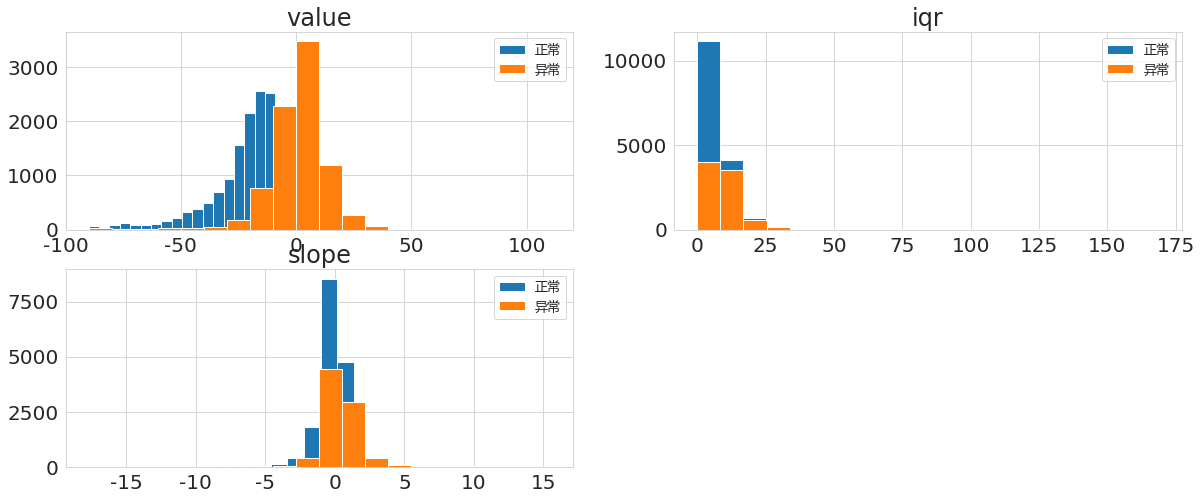

In [111]:
###  3. 特征分布
from matplotlib.font_manager import FontProperties
font = FontProperties(fname=r"/root/anaconda3/lib/python3.7/site-packages/matplotlib/mpl-data/fonts/ttf/msyh.ttc", size=13)
columns = ["value",'iqr','slope']
pl.figure(figsize=(20,8))
for index,col in enumerate(columns):
    pl.subplot(2,2,index+1)
    pl.hist(df1[df1.label==0][col],bins=20,label='正常')
    pl.hist(df1[df1.label==1][col],bins=20,label='异常')
    pl.legend(prop =font)
    pl.title(col)
pl.show()

## 四、模型训练

### 1. 采用 Logistic Regression 模型训练

In [15]:
columns = ["value",'iqr','slope']
X1 = df[columns].values
Y = df[['label']].values
model = linear_model.LogisticRegression(penalty = 'none',solver = 'saga', class_weight = 'balanced', max_iter=1000)
model.fit(X1,Y)
print(model.score(X1,Y))
print (model.coef_,model.intercept_)
df['Logistic'] = model.predict_proba(X1)[:,1]

c:\users\demo\appdata\local\programs\python\python37\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.9995833140423168
[[ 56.3743664   42.15570114 110.30220146]] [6.59685047]


c:\users\demo\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


In [16]:
## 保存因变量模型的 model
pickle.dump(model, open('./model/model_PH.pkl', 'wb'))

### 3. 阈值规则修正label

In [17]:
## 将温度超过 th 的 label 直接置成报警概率
temp = df.loc[df[df['PH']>0].index,"Logistic"]
df.loc[temp[temp<rate].index,"Logistic"] = rate
df['rate'] = rate
df['value'] = df['value']/df['value'].max()
print (df.index.min(),df.index.max())

2018-09-22 00:01:00 2018-10-06 23:59:00


In [18]:
df.to_csv("./data/process/PH_predict.csv")

### 4. 模型效果

In [19]:
me.Plot_LineBar(df,columns = ['value','Logistic','label','rate'],\
                name="PH_Label_Logistic_0",overwrite=True)

c:\users\demo\appdata\local\programs\python\python37\lib\site-packages\IPython\core\display.py:689: UserWarning: Consider using IPython.display.IFrame instead
  warnings.warn("Consider using IPython.display.IFrame instead")


In [97]:
df.to_csv("./data/process/PH_predict.csv")

## 5. 模型验证

In [120]:
### 1. 获取7月原始数据
cd= des[des['名称'].isin(nodes_id)].set_index('名称')['描述'].to_dict()
names = des[des['名称'].isin(nodes_id)]['名称'].tolist()
datas=  []
columns = []
for name in names:
    try:
        datas.append(kc1.ReadRawData(name,month="2019_07",factory="中碳能源"))
        columns.append(cd[name])
    except:
        print (name," is not exist")
data07 = pd.concat(datas,axis=1)
data07.columns = columns
data07 = data07.resample(step).mean().dropna()
temp = kf.SensorCal(df=data07[['脱硫塔出口氧量', '脱硫塔出口SO2']],sensor = '脱硫塔出口氧量')
data07 = temp['脱硫塔出口SO2']
print (data07.index.min(),data07.index.max())

2019-07-01 00:00:00 2019-07-23 23:59:00


In [127]:
###  2. 某些特征 用户可自行生成
### 1. 加工特征
s3 = kf.SingleTsFeature(data07-th)  ##  将原始温度 减去 温度阈值 加工特征
s3.add_roll_quantile(q = 0.75,window=roll_window,varname = "q3")
s3.add_roll_quantile(q = 0.25,window=roll_window,varname = "q1")
s3.add_slope(window=slope_window)
s3.add_label(th=0,left_window = '8min',right_window="2min",merge_window="5min",filename="label_auto")
df07 = s3.GetDf()
df07['value'] = df07['脱硫塔出口SO2'].rolling(value_window).max()
df07['iqr'] = df07['q3']-df07['q1']
df07 = df07.iloc[10:]
temp = df07[["value",'iqr','slope','label']]
temp = (temp-temp.min())/(temp.max()-temp.min())
me.Plot_LineBar(temp,name='SO2_Feature_label_07',overwrite=True)

add q3 successful 
add q1 successful 


../../../tool/Khfeature.py:200: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
  self._df[varname] = self._df[self._column].rolling(window=window).apply(kc1.gradient)


add_slope successful 


../../../tool/Khfeature.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  t['diff']= ((pd.Series(t.index).diff().dt.total_seconds()).values/S)
../../../tool/Khfeature.py:110: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  t['diff']= t['diff'].fillna(100)


save image as label_auto
add label successful 


In [131]:
X1 = df07[["value",'iqr','slope']].values
df07['Logistic'] = model.predict_proba(X1)[:,1]
temp = df07.loc[df07[df07['脱硫塔出口SO2']>0].index,"Logistic"]
df07.loc[temp[temp<rate].index,"Logistic"] = rate
df07['rate'] = rate
df07['value'] = df07['value']/df07['value'].max()

/root/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/root/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:189: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)
/root/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
/r

In [132]:
me.Plot_LineBar(df07[df07.index<"2019-07-20 12:00:00"],columns = ['value','Logistic','label','rate'],\
                name="SO2_Label_Logistic_2",overwrite=True)

In [134]:
me.Plot_LineBar(df07[df07.index>="2019-07-20 12:00:00"],columns = ['value','Logistic','label','rate'],\
                name="SO2_Label_Logistic_3",overwrite=True)